In [200]:
import numpy as np
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
from markov_bridges.configs.config_classes.data.music_configs import LakhPianoRollConfig

# Setup parameters and initial learning rate
params = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
initial_lr = 1e-4
data_config = LakhPianoRollConfig(batch_size=128)

num_epochs = 1000
num_steps_per_epochs = int(data_config.training_size/data_config.batch_size)
estimated_number_of_steps = num_epochs*num_steps_per_epochs

warm_up_steps = 5000
initial_warm_up_lr = initial_lr * np.minimum(float(1) / warm_up_steps, 1.0)

print(estimated_number_of_steps)
print(initial_warm_up_lr)

46000
2e-08


0.0001


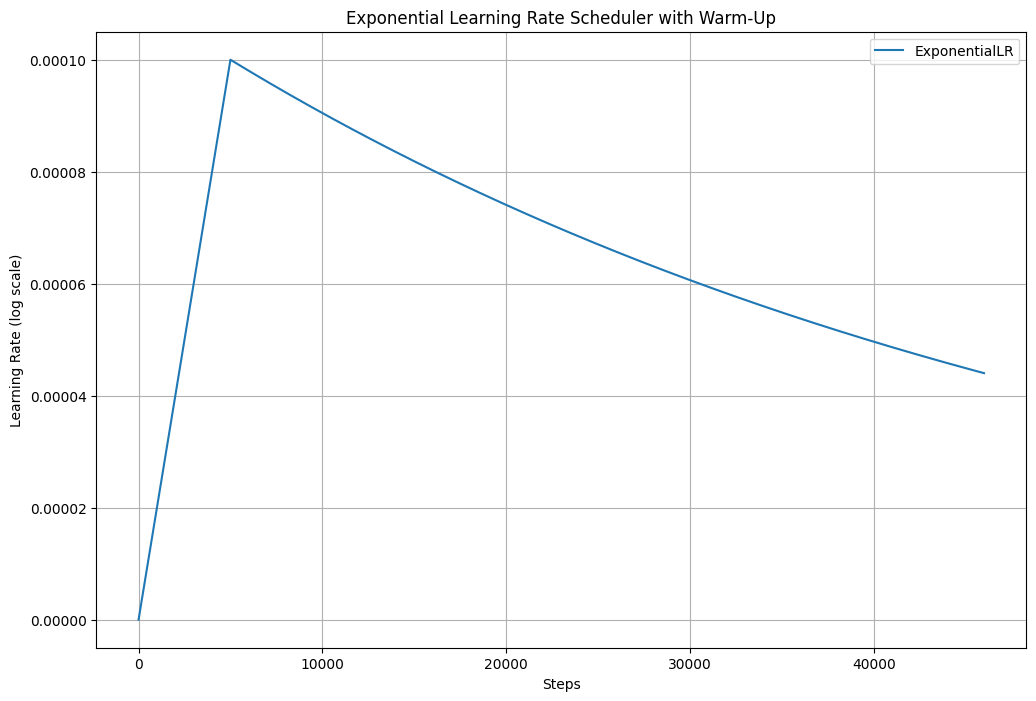

In [205]:
# if gamma = 1. for exponential learning rate, then he stays the same after the warm up
# is really sensitive to this number, only changing in the 5 decimal or so
# the smaller the faster the rate decas to ZERO
gamma = 0.99998

# Initialize optimizer and scheduler
optimizer = Adam(params, lr=initial_lr)
exponential_lrs = []

step = 0
for epoch in range(num_epochs):
    for _ in range(num_steps_per_epochs):
        # Warm-up logic
        if warm_up_steps > 0 and step <= warm_up_steps:
            lr = initial_lr * np.minimum(float(step) / warm_up_steps, 1.0)
            for g in optimizer.param_groups:
                g['lr'] = lr
            # Record the learning rate during warm-up
            exponential_lrs.append(optimizer.param_groups[0]['lr'])
        
        if step == warm_up_steps:
            # Capture the learning rate at the end of warm-up
            base_lr = optimizer.param_groups[0]['lr']
            # Reinitialize the optimizer and scheduler with the new base_lr
            optimizer = Adam(params, lr=base_lr)
            scheduler = ExponentialLR(optimizer, gamma=gamma)
            print(base_lr)
            
        # Dummy optimizer step
        optimizer.step()
        
        if step > warm_up_steps:
            # Update scheduler post-warm-up
            scheduler.step()
            # Record the learning rate post-warm-up
            exponential_lrs.append(optimizer.param_groups[0]['lr'])
        
        step += 1

# Plotting the learning rates with a logarithmic scale for the y-axis
plt.figure(figsize=(12, 8))
plt.plot(exponential_lrs[1:], label='ExponentialLR')
plt.xlabel('Steps')
plt.ylabel('Learning Rate (log scale)')
#plt.yscale('log')
plt.title('Exponential Learning Rate Scheduler with Warm-Up')
plt.legend()
plt.grid(True)
plt.show()
